In [1]:
# Import packages
from skimage.transform import rescale
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import glob, random, string
from PIL import Image, ImageDraw, ImageFont

In [2]:
# loading images 
images = glob.glob('../../GPU testings/data/lfw/**/*.jpg')

In [3]:
def add_logo(index):
    img = Image.open(str(images[index])).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))
    font = ImageFont.truetype("arial.ttf", 15)
    draw = ImageDraw.Draw(txt)
    width, height = img.size 
    for i in range(random.randint(0,10)):
        x=random.randint(0, width)
        y=random.randint(0, height)
        text = ''.join(random.SystemRandom().choice(string.ascii_letters + string.digits) for _ in range(random.randint(0,10)))
        draw.text((x,y), text, fill=(255,255,255, random.randint(100, 200)), font=font)
    
    imprinted_image = Image.alpha_composite(img, txt)
    rgb_imprinted_image = imprinted_image.convert('RGB')
    return rgb_imprinted_image.resize((192, 192))

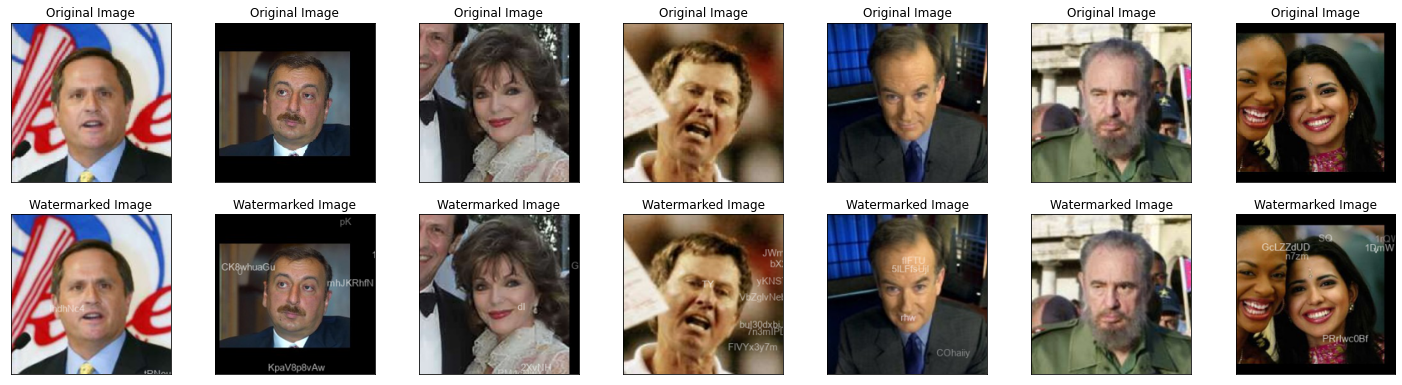

In [6]:
n = 7
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(images))
  img = image.load_img(str(images[index]), target_size=(192,192,3))
  image_resized = image.img_to_array(img)/255.
  plt.imshow(image_resized)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  logo_image = add_logo(index)
  plt.imshow(logo_image)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Watermarked Image')
plt.show()

In [5]:
# Building a Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

# Building the Encoder
input_img = Input(shape=(192, 192, 3))
l1 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(32, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.2)(l3)
l4 = Conv2D(64, (3, 3),  padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l6 = Dropout(0.2)(l6)
l7 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

l8 = MaxPooling2D(padding='same')(l7)
l8 = Dropout(0.2)(l8)
l9 = Conv2D(256, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)

In [6]:
# Building the Decoder
l10 = UpSampling2D()(l9)
l10 = Dropout(0.2)(l10)
l11 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l10)

l12 = add([l7, l11])
l13 = UpSampling2D()(l12)
l13 = Dropout(0.2)(l13)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)
l15 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l14)

l16 = add([l5, l14])
l17 = UpSampling2D()(l16)
l17 = Dropout(0.2)(l17)
l18 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l17)
l19 = Conv2D(32, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l18)

l20 = add([l18, l2])


In [7]:

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l20)

# Create our network
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

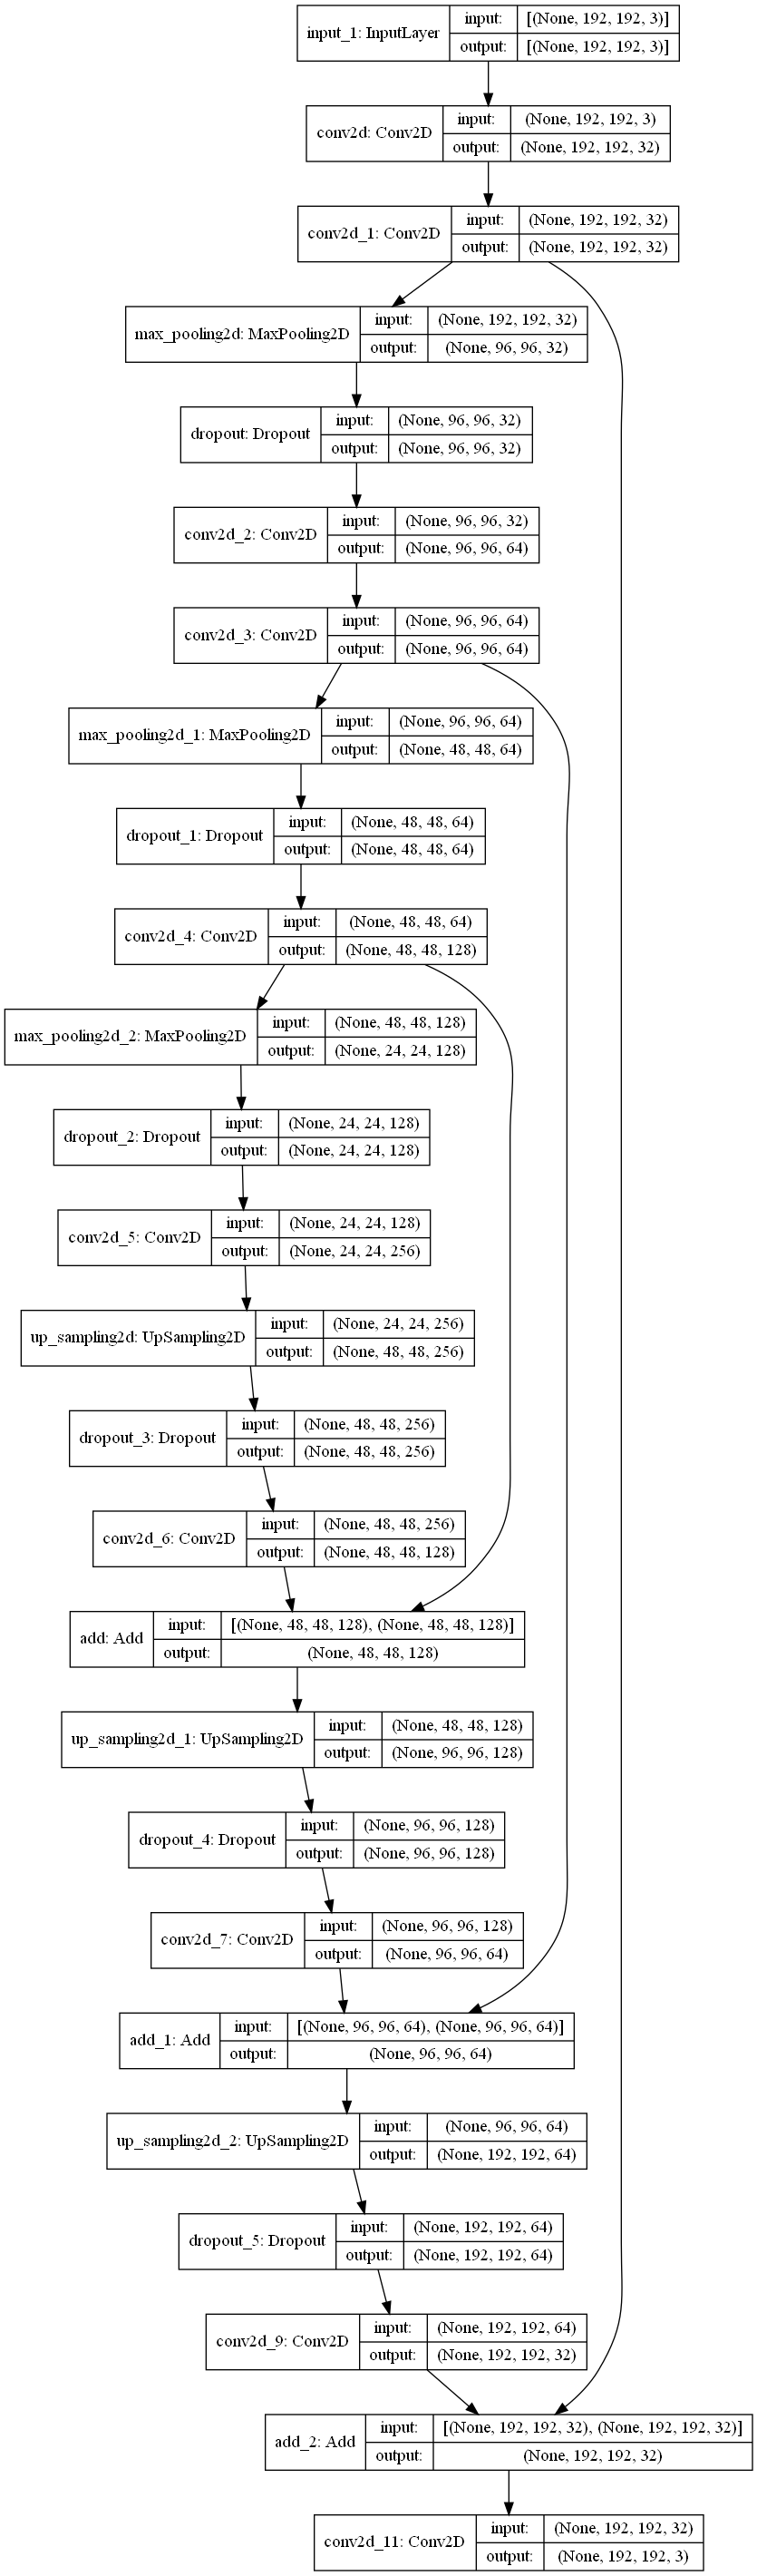

In [8]:
tf.keras.utils.plot_model(
    autoencoder,
    # to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    # show_layer_activations=False,
)

In [9]:
# Defining callback functions
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=8,
                             min_lr=0.00001, mode='auto', cooldown=2)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint =  ModelCheckpoint('LR_AutoEncoder.h5', save_best_only = True, monitor="val_accuracy")
callbacks = [reduce_lr, early_stop, model_checkpoint]

In [10]:
# Training the model
x_train_n = []
x_train_logo = []
print('Loading Train Data.....')
progress = tqdm(total = 10000, position = 0)
for x in range(10000):
  try:
      index = np.random.randint(0, len(images))
      img = image.load_img(str(images[index]), target_size=(192,192,3))
      image_resized = image.img_to_array(img)/255.
      x_train_n.append(image_resized)
      marked_image = add_logo(index)
      marked_image_np = image.img_to_array(marked_image)/255.
      x_train_logo.append(marked_image_np)
      
      del images[index]
      progress.update(1)
  except:
      del images[index]
      progress.update(1)
      print("Error loading image")

Loading Train Data.....


100%|█████████▉| 9998/10000 [01:51<00:00, 86.03it/s] 

In [11]:
print("Length: ", len(x_train_n))
print('Training the model....')
history_ae = autoencoder.fit(np.array(x_train_logo), np.array(x_train_n),
              epochs=100,
              batch_size=32,
              shuffle=True,
              validation_split=0.15,
              callbacks=callbacks)

Length:  10000
Training the model....
Epoch 1/100
  5/266 [..............................] - ETA: 1:15 - loss: 0.3799 - accuracy: 0.5049

100%|██████████| 10000/10000 [02:10<00:00, 86.03it/s]

266/266 [==============================] - 93s 320ms/step - loss: 0.0118 - accuracy: 0.8134 - val_loss: 0.0011 - val_accuracy: 0.8906
Epoch 2/100


d:\Users\KalburgS\Anaconda3\envs\pygames\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


266/266 [==============================] - 74s 280ms/step - loss: 9.3801e-04 - accuracy: 0.8911 - val_loss: 8.6348e-04 - val_accuracy: 0.8922
Epoch 3/100
266/266 [==============================] - 73s 275ms/step - loss: 8.2568e-04 - accuracy: 0.8997 - val_loss: 7.9162e-04 - val_accuracy: 0.8886
Epoch 4/100
266/266 [==============================] - 74s 278ms/step - loss: 7.6197e-04 - accuracy: 0.9055 - val_loss: 7.3034e-04 - val_accuracy: 0.8973
Epoch 5/100
266/266 [==============================] - 73s 275ms/step - loss: 7.1302e-04 - accuracy: 0.9092 - val_loss: 6.7380e-04 - val_accuracy: 0.9142
Epoch 6/100
266/266 [==============================] - 73s 275ms/step - loss: 6.8001e-04 - accuracy: 0.9128 - val_loss: 6.5557e-04 - val_accuracy: 0.9328
Epoch 7/100
266/266 [==============================] - 73s 275ms/step - loss: 6.4302e-04 - accuracy: 0.9183 - val_loss: 6.1930e-04 - val_accuracy: 0.9242
Epoch 8/100
266/266 [==============================] - 73s 274ms/step - loss: 6.2184e-04

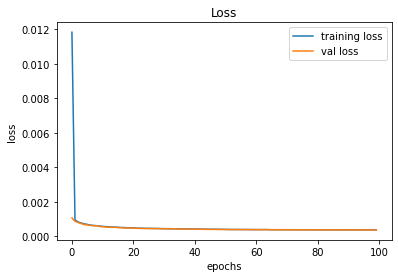

In [12]:
# Plotting graphs for loss
plt.plot(history_ae.history['loss'], label='training loss')
plt.plot(history_ae.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

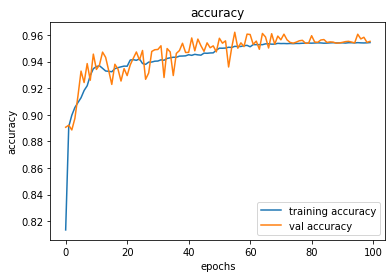

In [13]:
# Plotting graphs for Accuracy
plt.plot(history_ae.history['accuracy'], label='training accuracy')
plt.plot(history_ae.history['val_accuracy'], label='val accuracy')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

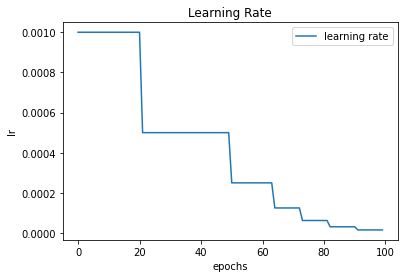

In [14]:
# Plotting graphs for lr
plt.plot(history_ae.history['lr'], label='learning rate')
plt.title('Learning Rate')
plt.xlabel('epochs')
plt.ylabel('lr')
plt.legend()
plt.show()

In [22]:
x_test_n = []
x_test_logo = []
progress = tqdm(total= len(images), position=0)
for idx, img in enumerate(images):
  img = image.load_img(str(img), target_size=(192,192,3))
  image_resized = image.img_to_array(img)/255.
  x_test_n.append(image_resized)
  marked_image = add_logo(idx)
  marked_image_np = image.img_to_array(marked_image)/255.
  x_test_logo.append(marked_image_np)
  progress.update(1)

100%|█████████▉| 3231/3233 [00:37<00:00, 91.55it/s] 

In [23]:
print('Loss and Accuracy on test data....')
results = autoencoder.evaluate(np.array(x_test_logo), np.array(x_test_n))

Loss and Accuracy on test data....
 97/102 [===========================>..] - ETA: 0s - loss: 3.6005e-04 - accuracy: 0.9537

100%|██████████| 3233/3233 [00:50<00:00, 91.55it/s]

102/102 [==============================] - 7s 65ms/step - loss: 3.6009e-04 - accuracy: 0.9538


In [24]:
predictions = autoencoder.predict(np.array(x_test_logo))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


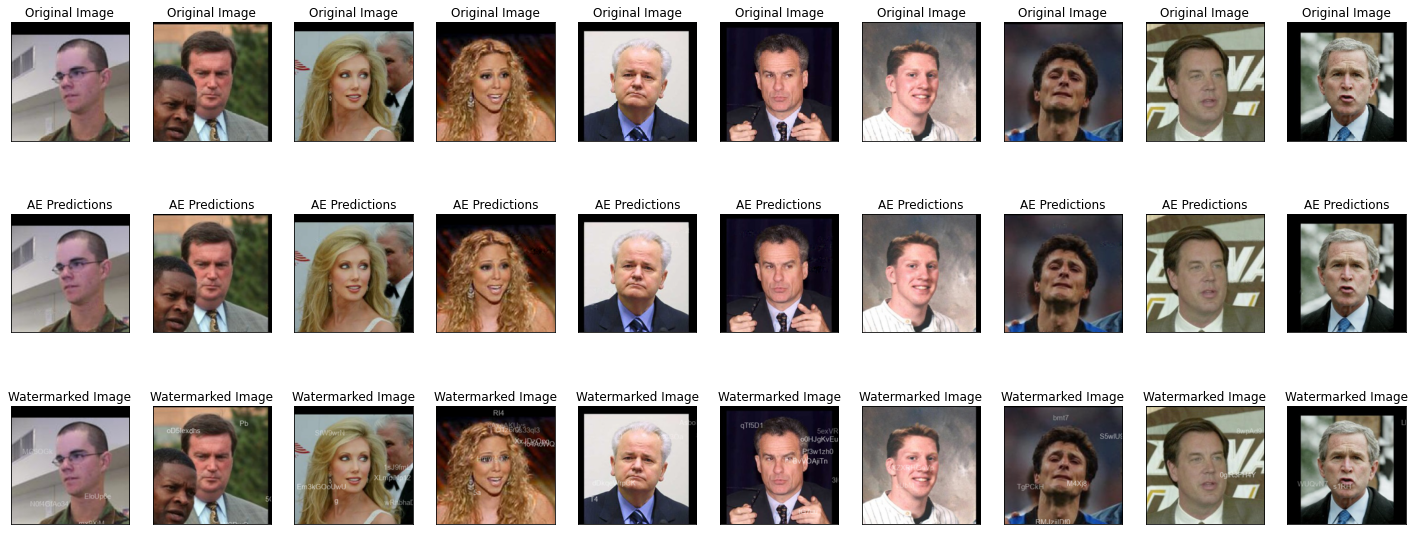

In [27]:
n = 10
plt.figure(figsize= (25,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  index = np.random.randint(0, len(x_test_logo))
  plt.imshow(x_test_n[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Original Image')
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('AE Predictions')
  ax = plt.subplot(3, n, i+11+n)
  plt.imshow(x_test_logo[index])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.title('Watermarked Image')
plt.show()

In [28]:
# Represeting Model as JSON String
autoencoder_json = autoencoder.to_json()
with open('LR_model.json', 'w') as json_file:
  json_file.write(autoencoder_json)

d:\Users\KalburgS\Anaconda3\envs\pygames\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
